# Imports

In [1]:
%%capture
!chmod -R 777 ../

In [2]:
# System and path operations
import sys
import os
import datetime
from pathlib import Path
from glob import glob
sys.path.insert(0, '../')

# Imported local modules
from src.config import *
from src.utils import *
from src.models_arch import *
from src.models_utils import *
from src.prepare_data import *

# Setting seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from ultralytics import YOLO
# import tensorflow as tf
import torch
from PIL import Image
# import torchvision.transforms as T

import cv2
import shutil

2023-08-13 19:59:21.569844: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 19:59:21.613456: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 19:59:21.614208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-13 19:59:22.599747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from PIL import Image
import numpy as np
import os

def save_images_and_masks(images, masks, root_dir='test'):
    # Ensure root_dir exists
    os.makedirs(root_dir, exist_ok=True)

    # Create directories for images and masks
    img_dir = os.path.join(root_dir, 'images')
    mask_dir = os.path.join(root_dir, 'masks')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    # Loop through all the images and masks and save them
    for i in range(images.shape[0]):
        img = Image.fromarray((images[i] * 255).astype(np.uint8))
        img.save(os.path.join(img_dir, f'img_{i:04d}.png'))

        mask = Image.fromarray((masks[i, :, :, 0] * 255).astype(np.uint8))
        mask.save(os.path.join(mask_dir, f'img_{i:04d}.png'))

# Example usage:
# images = np.random.randint(0, 256, size=(62, 256, 256, 3), dtype=np.uint8)
# masks = np.random.randint(0, 2, size=(62, 256, 256, 1), dtype=np.uint8)
# save_images_and_masks(images, masks)

images, masks = get_SPARCS('train', only_rgb=True)
save_images_and_masks(images, masks, Path(yolo_data_dir, 'train'))

images, masks = get_SPARCS('valid', only_rgb=True)
save_images_and_masks(images, masks, Path(yolo_data_dir, 'val'))

images, masks = get_SPARCS('test', only_rgb=True)
save_images_and_masks(images, masks, Path(yolo_data_dir, 'test'))


# images, masks = get_biome8('train', only_rgb=True)
# save_images_and_masks(images, masks, Path(yolo_data_dir, 'train'))

# images, masks = get_biome8('valid', only_rgb=True)
# save_images_and_masks(images, masks, Path(yolo_data_dir, 'val'))

# images, masks = get_biome8('test', only_rgb=True)
# save_images_and_masks(images, masks, Path(yolo_data_dir, 'test'))


In [4]:
os.listdir(yolo_data_dir)

['val', 'train', 'test']

In [5]:
from rasterio import features

def create_label(input_dir, output_dir):
    # input_dir = '/home/floddo/cloud_coverage_TOELT_SUPSI/yolov8/tmp/masks'
    # output_dir = '/home/floddo/cloud_coverage_TOELT_SUPSI/yolov8/tmp/labels'

    for j in os.listdir(input_dir):
        image_path = os.path.join(input_dir, j)
        # load the binary mask and get its contours
        mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

        H, W = mask.shape
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # convert the contours to polygons
        polygons = []
        for cnt in contours:
            # if cv2.contourArea(cnt) > 200:
            #     polygon = []
            #     for point in cnt:
            #         x, y = point[0]
            #         polygon.append(x / W)
            #         polygon.append(y / H)
            #     polygons.append(polygon)
            
            if cv2.contourArea(cnt) > 50:
                polygon = []
                for point in cnt:
                    x, y = point[0]
                    polygon.append(x / W)
                    polygon.append(y / H)
                polygons.append(polygon)

        # print the polygons
        with open('{}.txt'.format(os.path.join(output_dir, j)[:-4]), 'w') as f:
            for polygon in polygons:
                for p_, p in enumerate(polygon):
                    if p_ == len(polygon) - 1:
                        f.write('{}\n'.format(p))
                    elif p_ == 0:
                        f.write('0 {} '.format(p))
                    else:
                        f.write('{} '.format(p))

            f.close()

for split_dir in os.listdir(yolo_data_dir):
    input_dir = os.path.join(yolo_data_dir, split_dir, 'masks')
    output_dir = os.path.join(yolo_data_dir, split_dir, 'labels')
    os.makedirs(output_dir, exist_ok=True)
    create_label(input_dir, output_dir)
    
    # Check if the directory exists
    if os.path.exists(input_dir):
        # Remove the directory and all its contents
        shutil.rmtree(input_dir)
    else:
        print("The directory does not exist")


In [6]:
import cv2
import numpy as np
import glob

def read_annotation(annotation_path, H, W):
    # Read the annotation file or handle glob pattern
    if '*' in annotation_path:
        annotation_files = sorted(glob.glob(annotation_path))
    else:
        annotation_files = [annotation_path]

    masks = []

    # Process each annotation file
    for ann_file in annotation_files:
        # Initialize an empty mask
        mask = np.zeros((H, W), dtype=np.uint8)

        # Read the annotation file
        with open(ann_file, 'r') as f:
            lines = f.readlines()

        # Create a list to hold all polygons
        polygons = []

        # Process each line
        for line in lines:
            # Remove the leading '0 ' and the trailing '\n', then split the line into coordinates
            coords = line[2:-1].split(' ')

            # Process the coordinates in pairs and add them to the polygon
            polygon = [(float(coords[i]) * W, float(coords[i+1]) * H) for i in range(0, len(coords), 2)]
            polygons.append(polygon)

        # Draw the polygons on the mask
        for polygon in polygons:
            # The fillPoly function expects an array of polygons, where each polygon is an array of points,
            # but each point needs to be a 1-by-2 array, hence the extra wrapping with np.array and the reshaping
            cv2.fillPoly(mask, [np.array(polygon, dtype=np.int32).reshape(-1, 1, 2)], 255)
        
        mask = np.where(mask > 0, 1, 0)
        masks.append(mask)

    return np.array(masks)

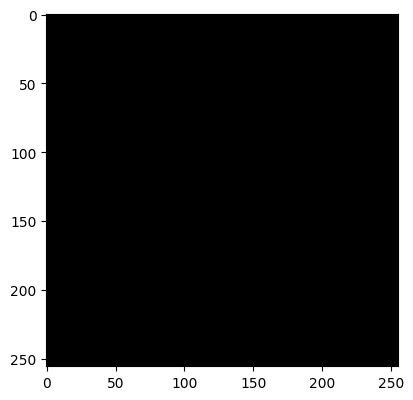

In [7]:
import numpy as np
import cv2
import os

# def read_annotation(annotation_path, H, W):
#     # Initialize an empty mask
#     mask = np.zeros((H, W), dtype=np.uint8)

#     # Read the annotation file
#     with open(annotation_path, 'r') as f:
#         lines = f.readlines()

#     # Create a list to hold all polygons
#     polygons = []
    
#     # Process each line
#     for line in lines:
#         # Remove the leading '0 ' and the trailing '\n', then split the line into coordinates
#         coords = line[2:-1].split(' ')

#         # Process the coordinates in pairs and add them to the polygon
#         polygon = [(float(coords[i]) * W, float(coords[i+1]) * H) for i in range(0, len(coords), 2)]
#         polygons.append(polygon)

#     # Draw the polygons on the mask
#     for polygon in polygons:
#         # The fillPoly function expects an array of polygons, where each polygon is an array of points,
#         # but each point needs to be a 1-by-2 array, hence the extra wrapping with np.array and the reshaping
#         cv2.fillPoly(mask, [np.array(polygon, dtype=np.int32).reshape(-1, 1, 2)], 255)

#     return mask

m1 = read_annotation('/home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/val/labels/img_0000.txt', 256, 256)
# m1 = read_annotation('/home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/labels/img_15.txt', 256, 256)

# m2 = cv2.imread('/home/floddo/cloud_coverage_TOELT_SUPSI/Data/SPARCS/YOLO/val/masks/img_0.png', cv2.IMREAD_GRAYSCALE)
# Subplot of the thow masks
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(m1[0], cmap='gray')
# plt.subplot(1, 2, 2)
# plt.imshow(m2, cmap='gray')

# setup

In [8]:
yaml_content = f'''
path: {yolo_data_dir}/
train: train/images
val: val/images
test: test/images

#Classes
nc: 1 

#classes names
names: ['cloud']
'''

config_path = Path(notebooks_path, 'sparcs-seg.yaml')

with config_path.open('w') as f:
    f.write(yaml_content)

# Run model

In [9]:
model = YOLO('yolov8n-seg.yaml').load('yolov8x-seg.pt')  # build from YAML and transfer weights
# model = YOLO('yolov8n-seg.yaml')
results = model.train(
        batch=16,
        device=[3],
        data="sparcs-seg.yaml",
        epochs=100,
        imgsz=256,
        name='yolov8n_pre_epochs100_batch16',
    )


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1   1150432  ultralytics.nn.modules.head.Segment          [80, 32, 64, [64, 128, 256]]  
YOLOv8n-seg summary: 261 layers, 3409968 parameters, 3409952 gradients

100%|██████████| 137M/137M [00:05<00:00, 28.3MB/s] 
Transferred 80/417 items from pretrained weights
New https://pypi.org/project/ultralytics/8.0.153 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.142 🚀 Python-3.9.17 torch-2.0.1+cu117 CUDA:3 (NVIDIA GeForce RTX 3090, 24268MiB)
engine/trainer: task=segment, mode=train, model=yolov

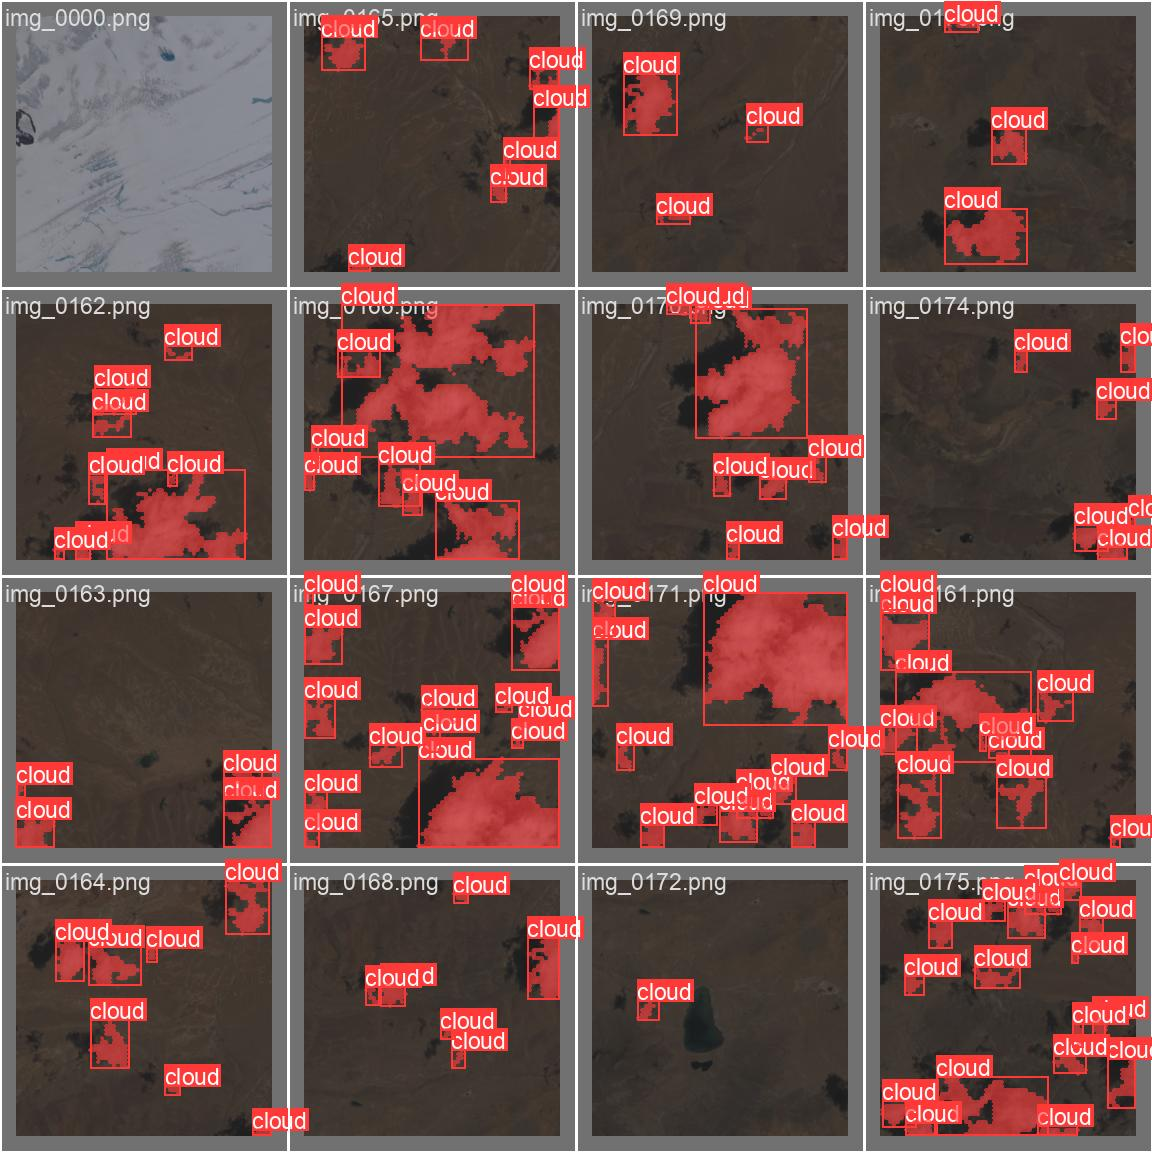

In [10]:
from IPython.display import Image as show_image
show_image(filename=notebooks_path / "runs/segment/yolov8n_pre_epochs100_batch16/val_batch0_labels.jpg")

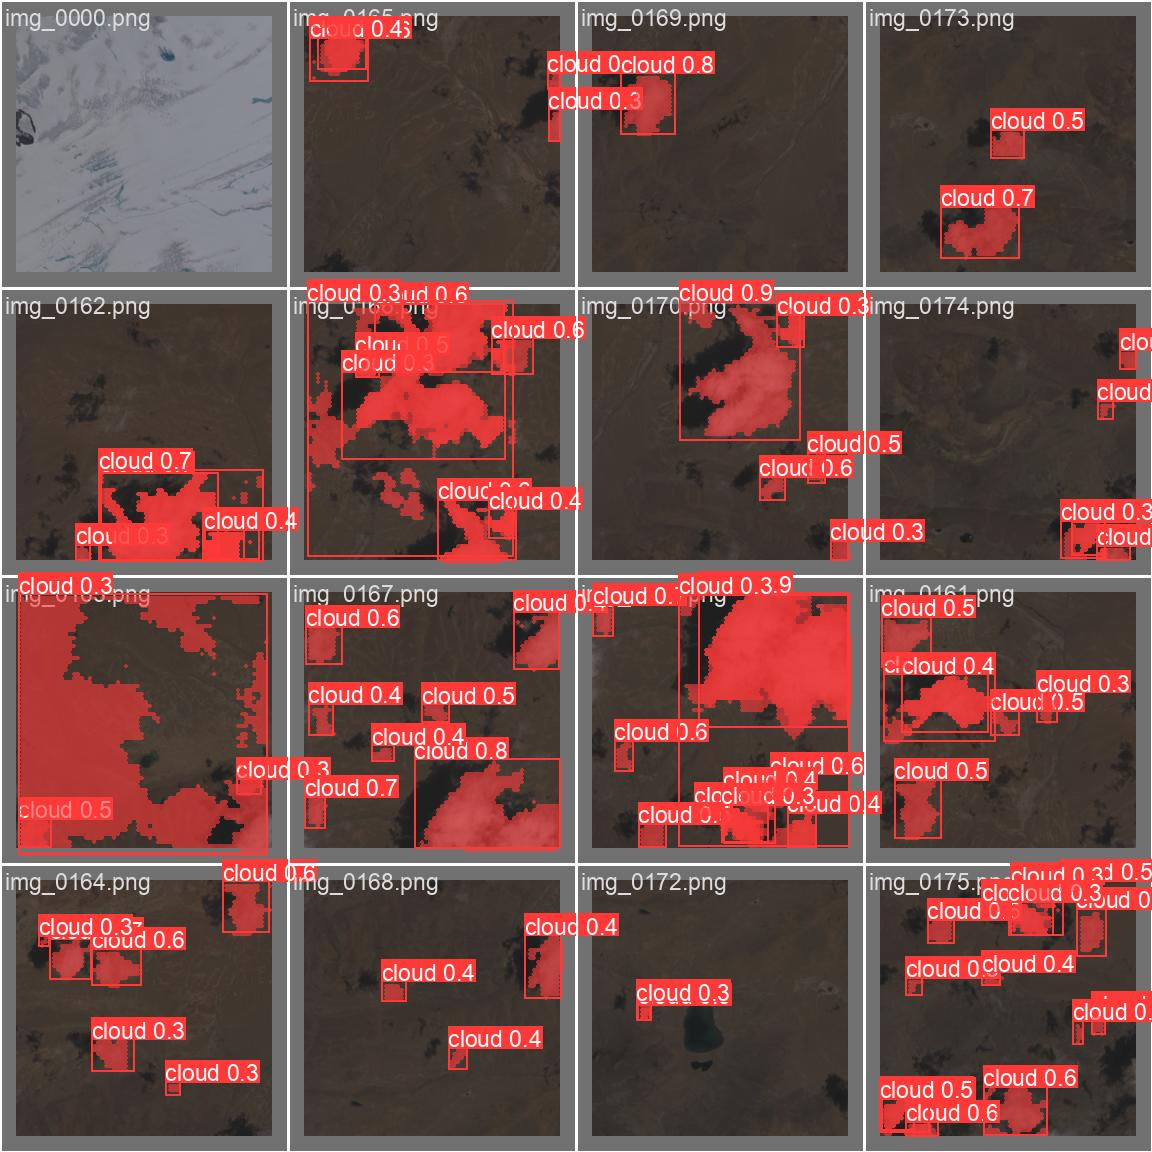

In [11]:
show_image(filename=notebooks_path / "runs/segment/yolov8n_pre_epochs100_batch16/val_batch0_pred.jpg")

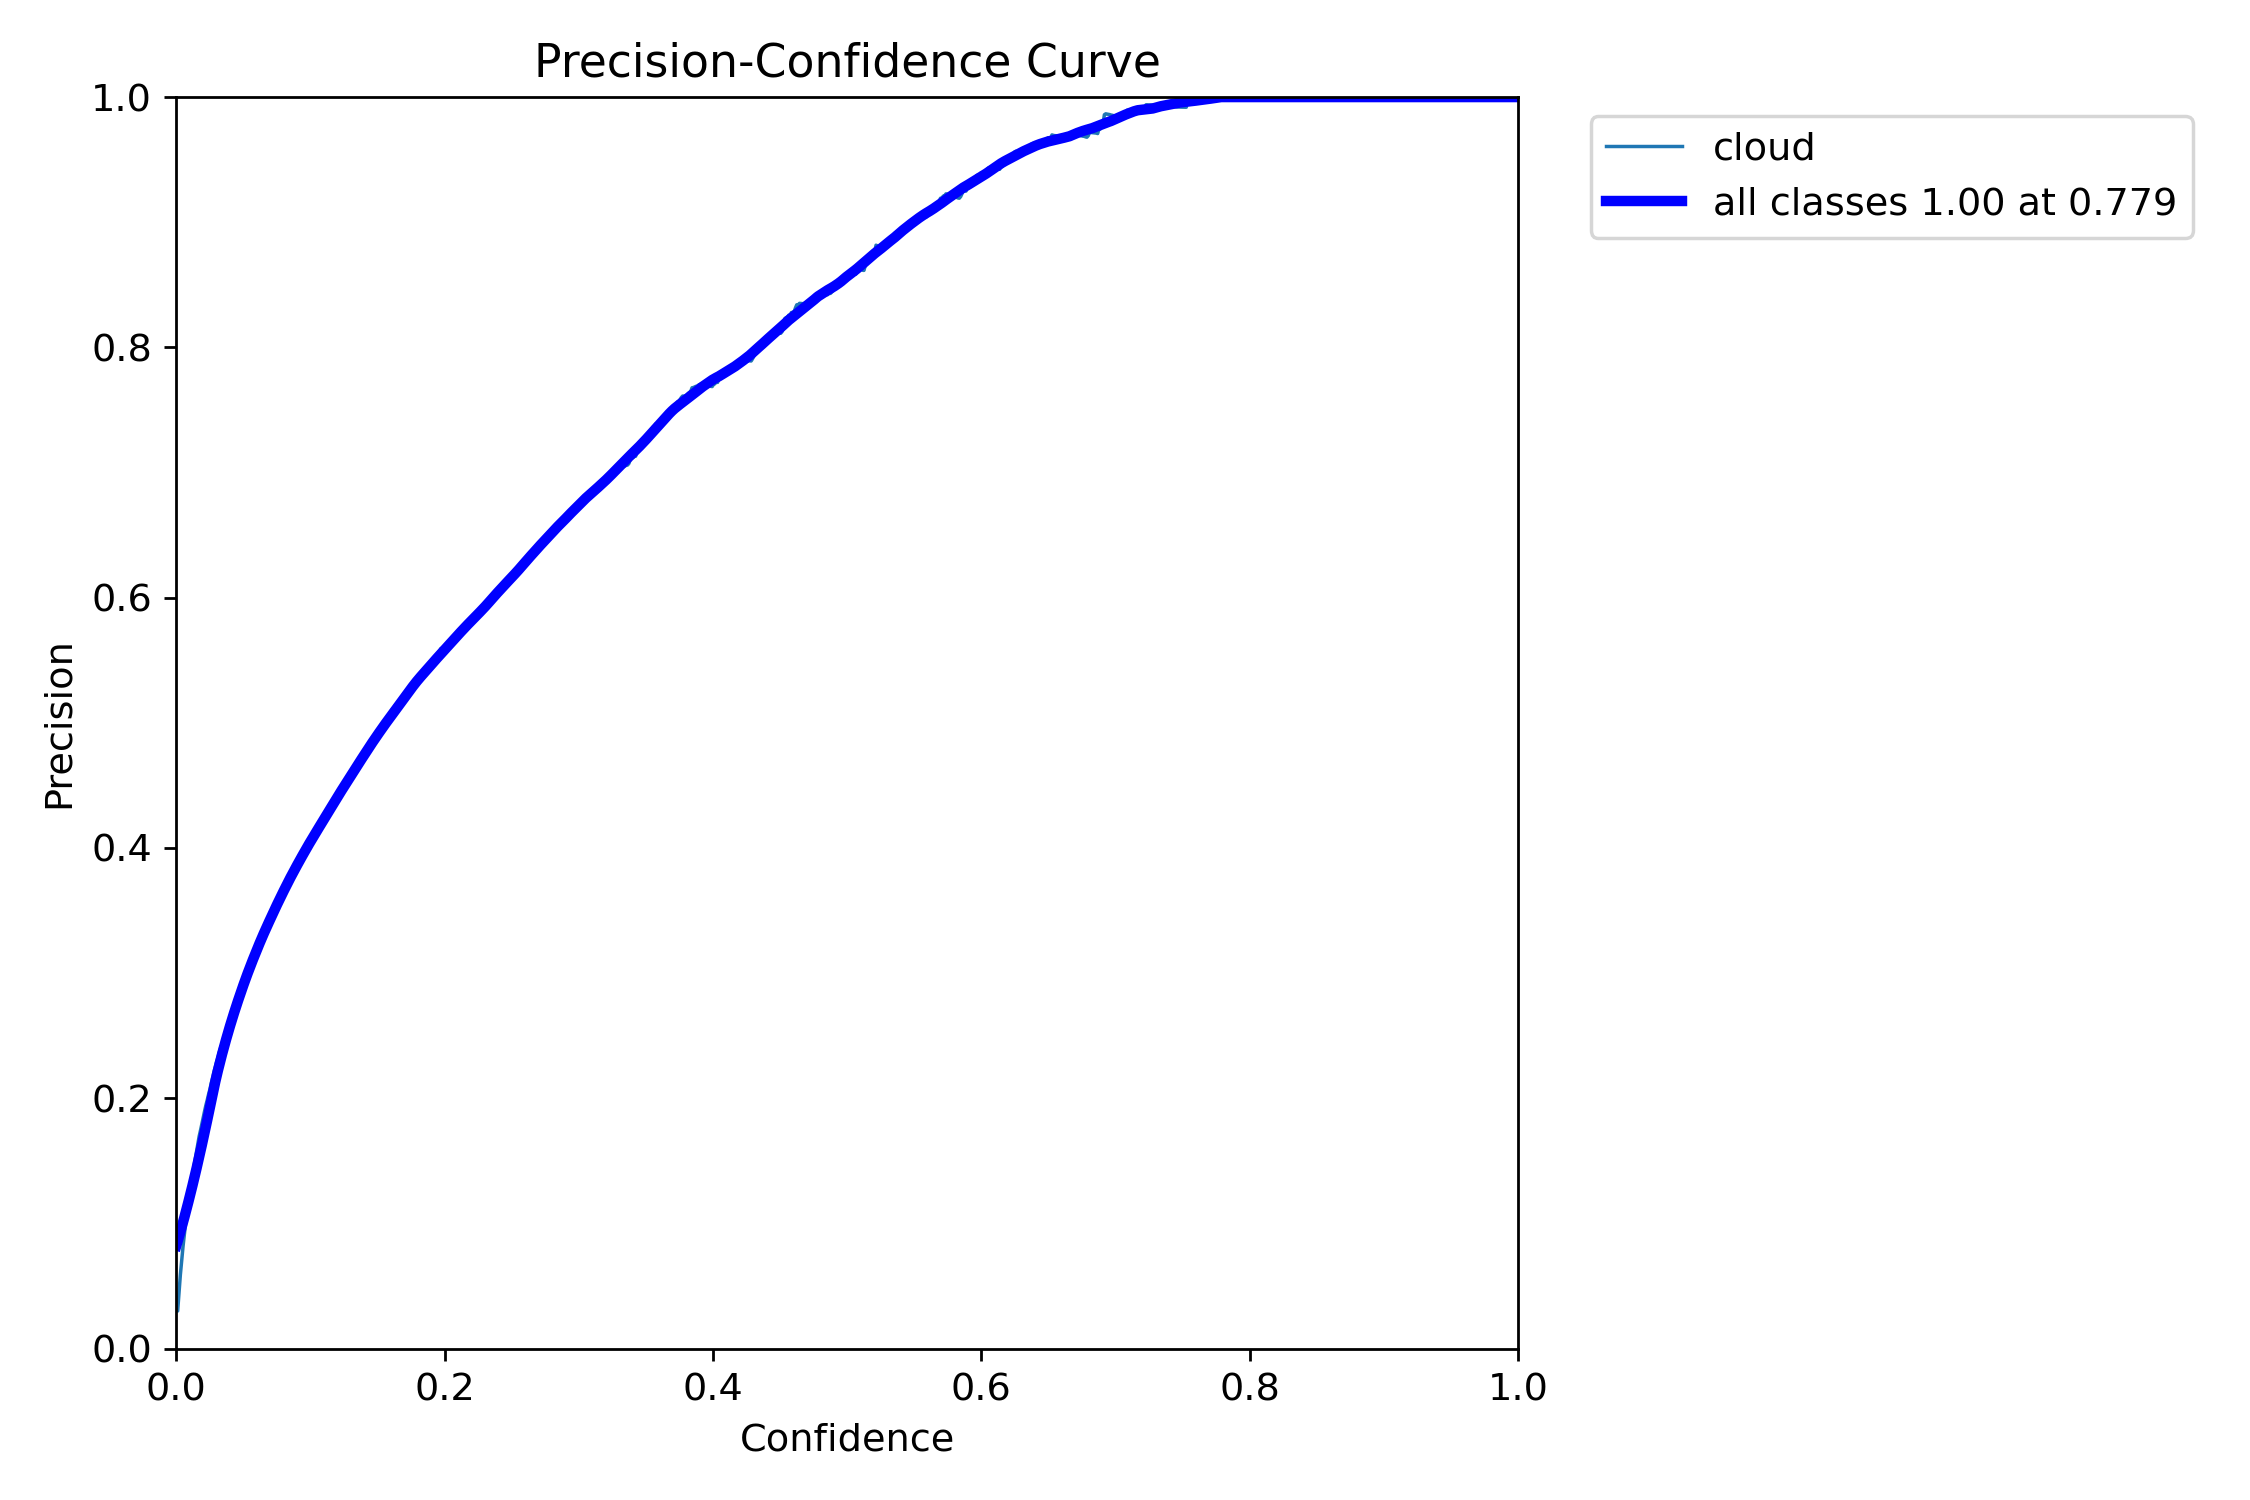

In [12]:
show_image(filename=notebooks_path / "runs/segment/yolov8n_pre_epochs100_batch16/MaskP_curve.png")

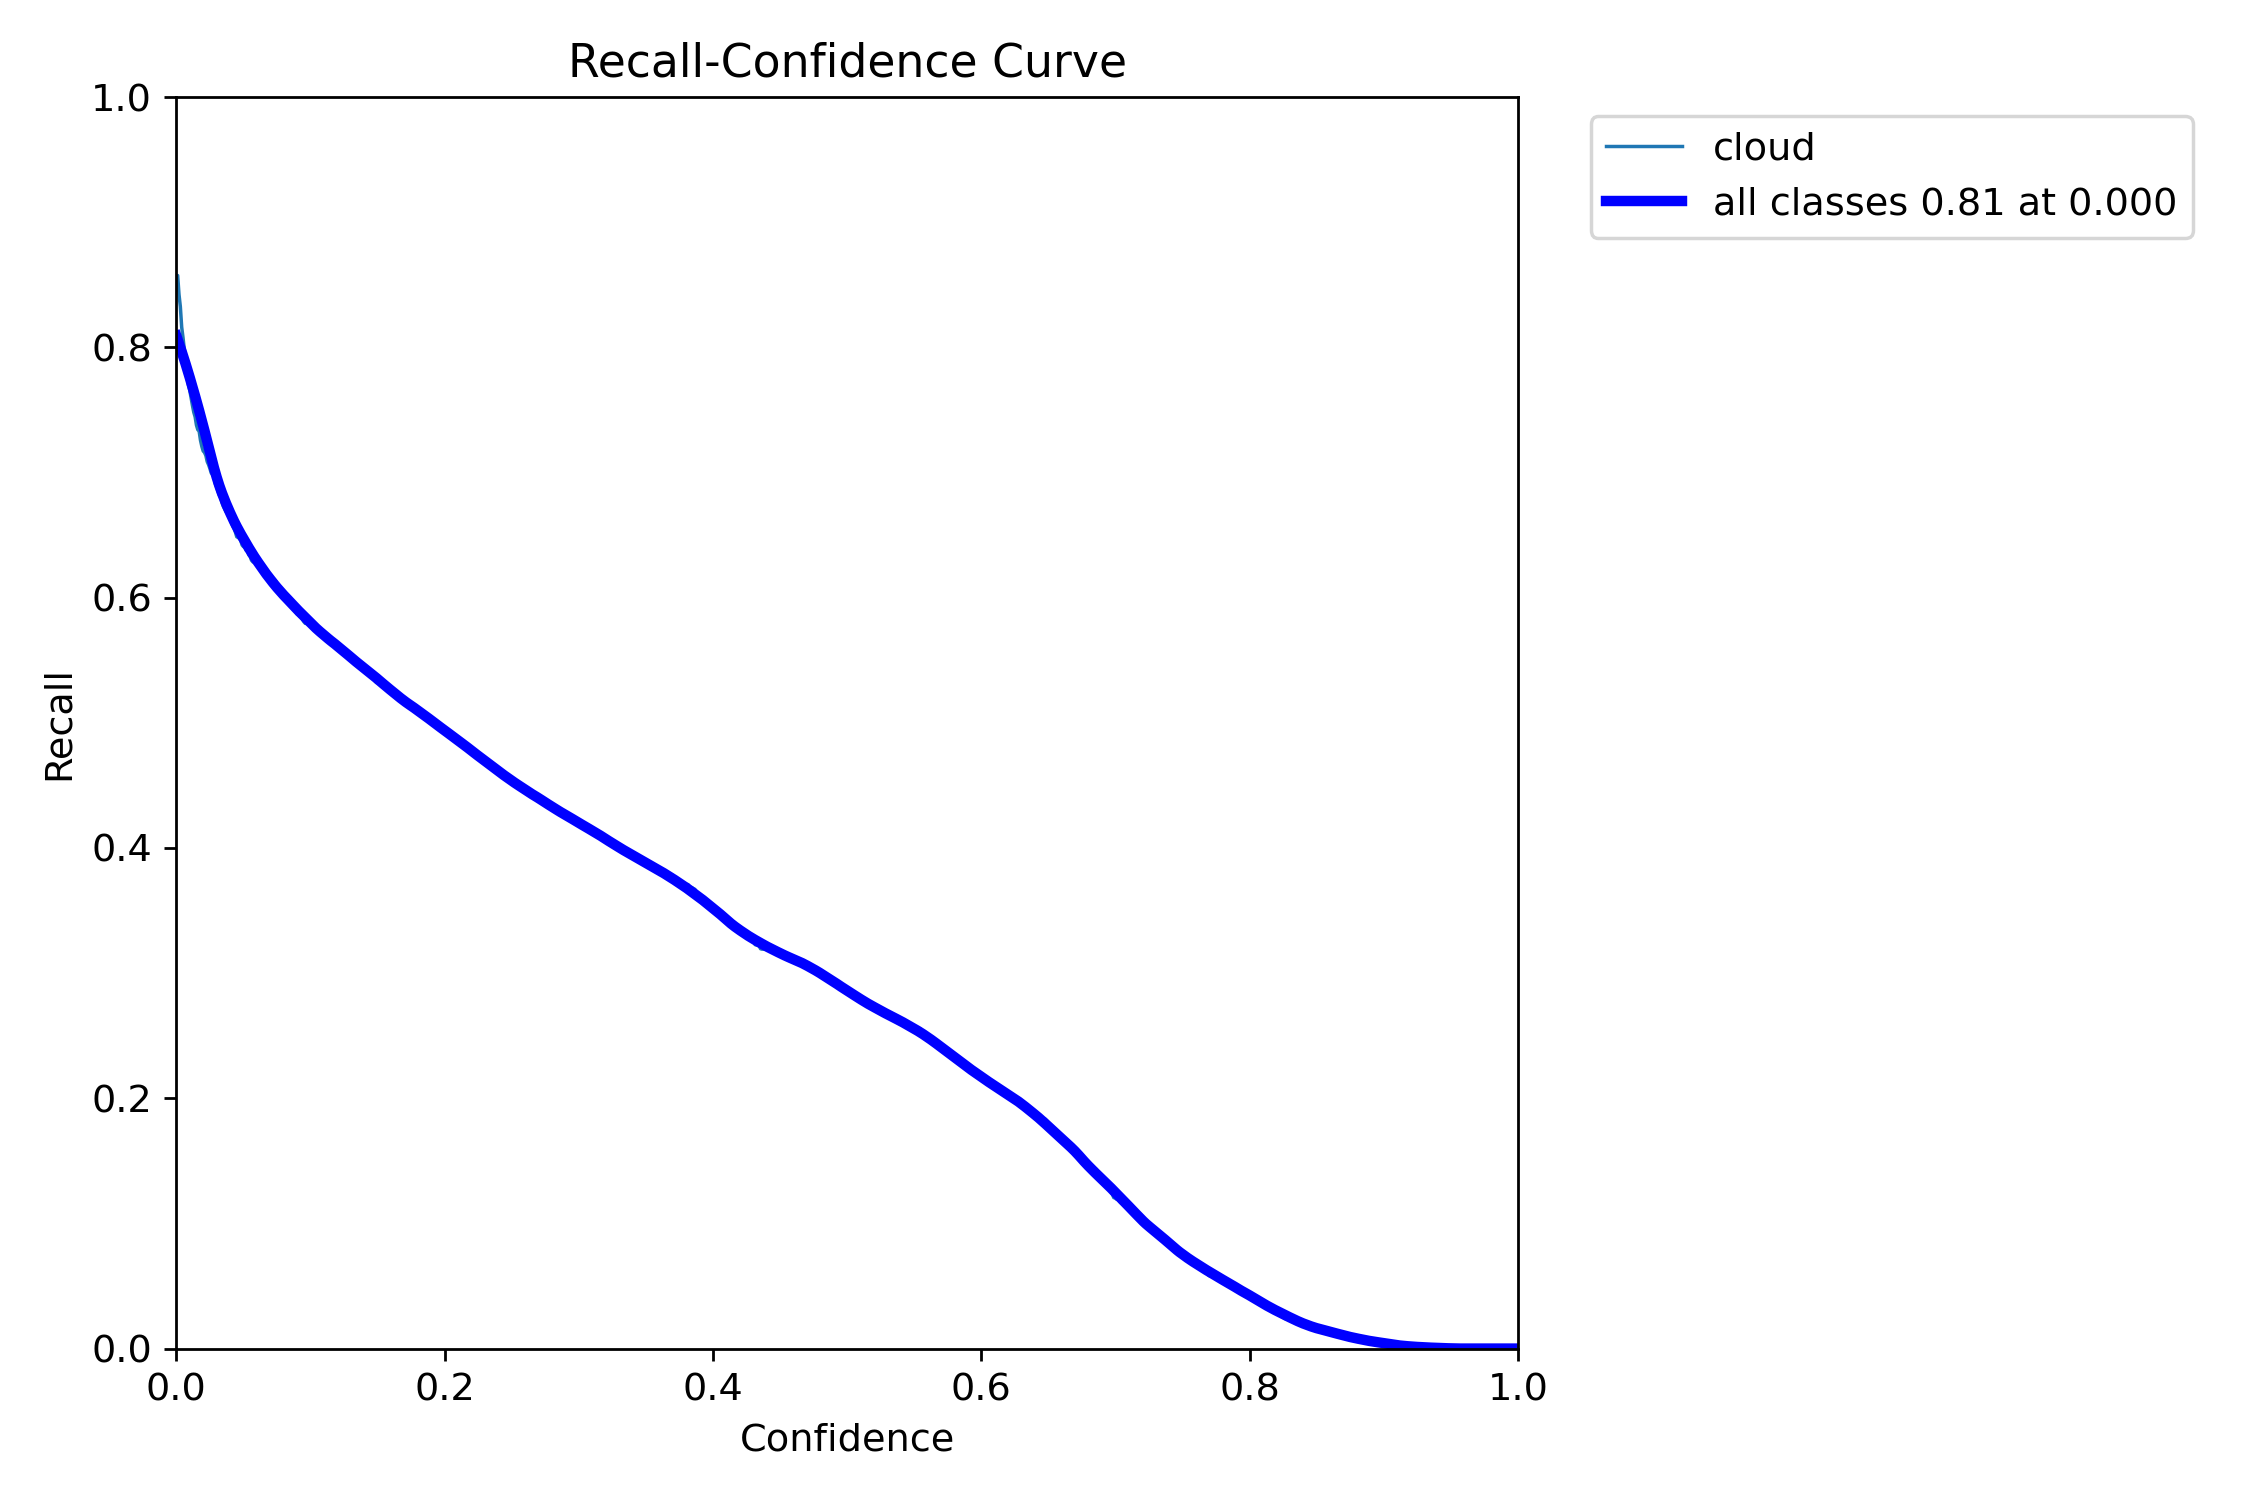

In [13]:
show_image(filename=notebooks_path / "runs/segment/yolov8n_pre_epochs100_batch16/MaskR_curve.png")

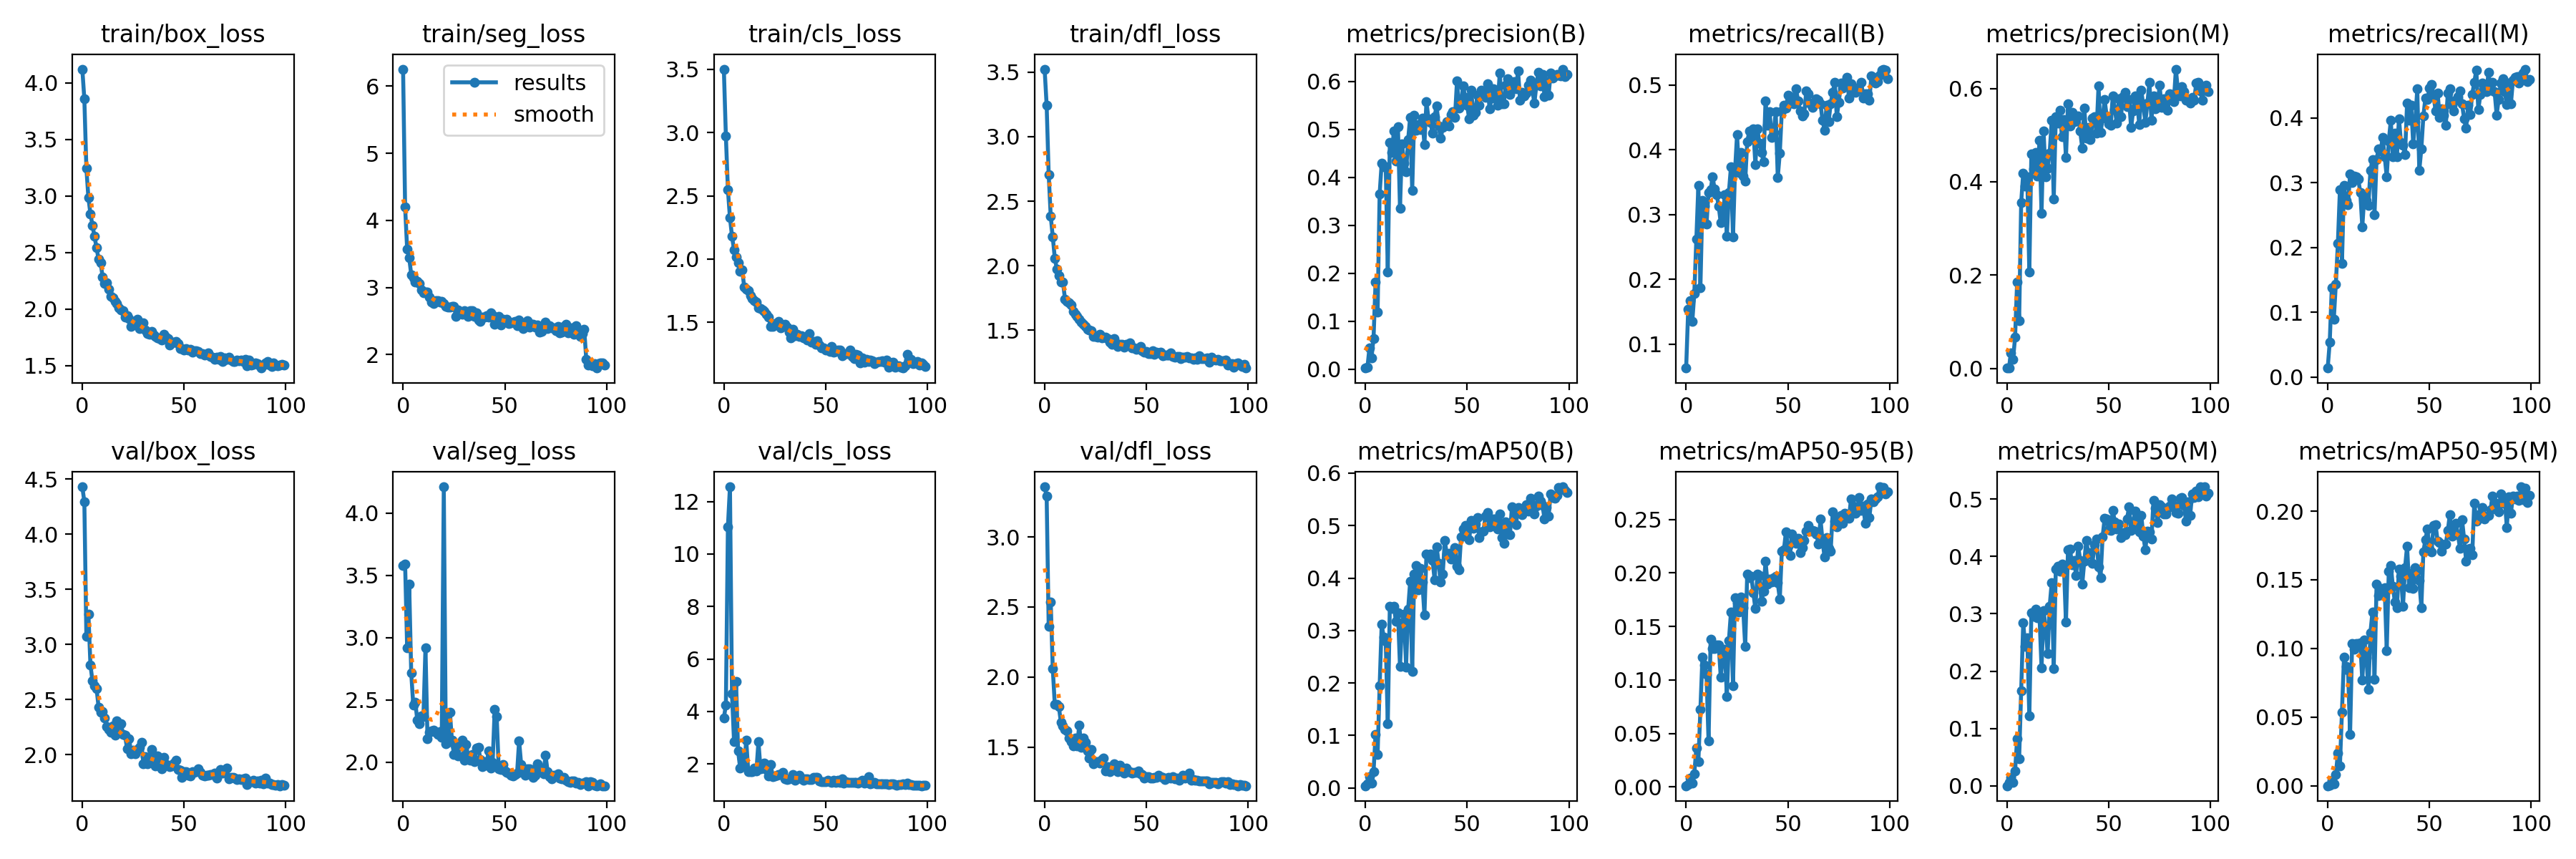

In [14]:
show_image(filename=notebooks_path / "runs/segment/yolov8n_pre_epochs100_batch16/results.png")


# Predict

In [91]:
source = yolo_data_dir / 'test/images/*.png'
source

PosixPath('/home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/*.png')

In [15]:
my_model = YOLO(notebooks_path / 'runs/segment/yolov8n_pre_epochs100_batch16/weights/best.pt')
# results = list(my_model((yolo_data_dir / 'test/images/img_0111.png'), conf=0.882))
source = yolo_data_dir / 'test/images/*.png'
source = yolo_data_dir / 'test/images'

results = list(my_model(source, conf=0.3))
result = results[0]


image 1/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0000.png: 256x256 11 clouds, 6.2ms
image 2/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0001.png: 256x256 13 clouds, 6.0ms
image 3/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0002.png: 256x256 10 clouds, 5.8ms
image 4/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0003.png: 256x256 13 clouds, 6.0ms
image 5/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0004.png: 256x256 11 clouds, 6.3ms
image 6/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0005.png: 256x256 12 clouds, 5.8ms
image 7/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0006.png: 256x256 10 clouds, 5.9ms
image 8/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0007.png: 256x256 10 clouds, 5.8ms
image 9/256 /home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0008.png: 256x256

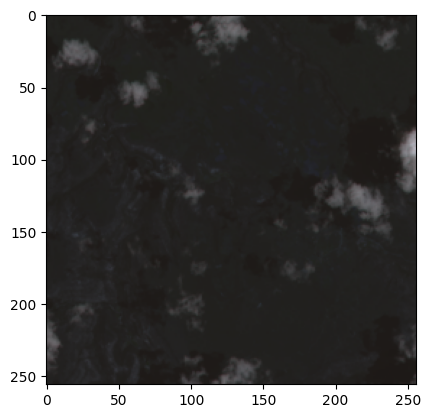

In [16]:
plt.imshow(result.orig_img)

In [ ]:
# for result in results:
#     if result.masks is None:
#         print(np.unique(np.zeros((256, 256), dtype=np.float32)))
#         continue
#     n = np.unique(result.masks.data.cpu().numpy())


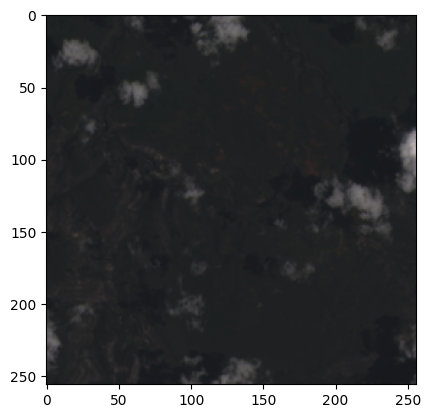

In [18]:
plt.imshow(imread('/home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/images/img_0000.png'))

In [19]:
masks = read_annotation('/home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/labels/*.txt', 256, 256)
# masks = read_annotation('/home/floddo/cloud_coverage_TOELT_SUPSI/Data/YOLO/test/labels/img_0.txt', 256, 256)
masks = np.expand_dims(masks, axis=-1)

masks.shape, np.unique(masks)

((256, 256, 256, 1), array([0, 1]))

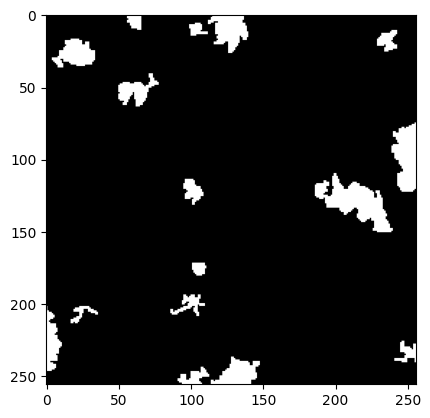

In [20]:
plt.imshow(masks[0], cmap='gray')

In [21]:
# Initialize an empty list to hold the individual masks
individual_masks = []

# Iterate through the results
for result in results:
    if result.masks is None:
        # If no detection, add a zero mask
        individual_masks.append(np.zeros((256, 256), dtype=np.float32))
    else:
        # Sum up the binary masks along the first dimension (axis 0)
        combined_mask = torch.sum(result.masks.data, dim=0).cpu().numpy()
        individual_masks.append(combined_mask)

# Convert the list of individual masks to a numpy array
combined_masks_array = np.array(individual_masks)

combined_masks_array = np.expand_dims(combined_masks_array, axis=-1)

# Threshold the combined masks to create a binary mask
binary_combined_masks = np.where(combined_masks_array > 0, 1, 0)

# Sum up the individual masks along the first dimension to get the final combined mask
# final_combined_mask = np.sum(combined_masks_array, axis=0)

binary_combined_masks.shape, np.unique(binary_combined_masks)

((256, 256, 256, 1), array([0, 1]))

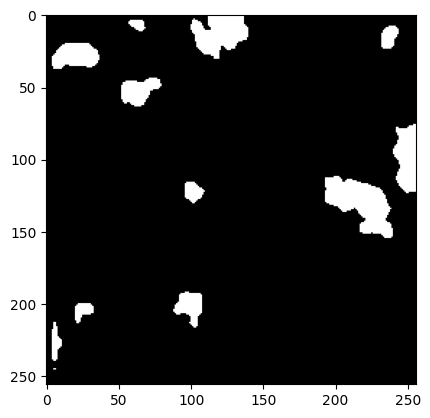

In [22]:
plt.imshow(binary_combined_masks[0], cmap='gray')

In [23]:
# Squeeze the first dimension
result = results[0]
combined_mask = torch.sum(result.masks.data, dim=0).cpu().numpy()
combined_mask.shape
# result.masks.data.shape

(256, 256)

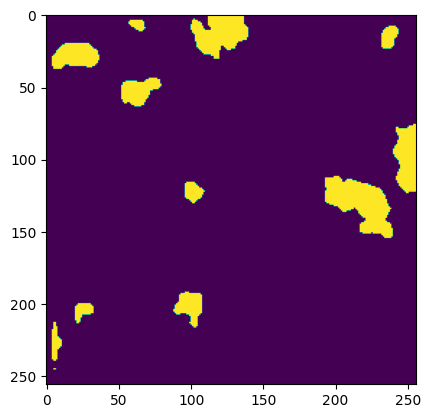

In [24]:
plt.imshow(combined_mask)

In [25]:
from src.metrices import *

print_m(masks, binary_combined_masks)

Jaccard Index 0.3981339280422548
final f1 0.47424334715009075
final precision 0.5231032729069267
final recall 0.43373113449976514
Overall Accuracy 0.9424154758453369
final aji 0.710584936521536


In [ ]:
# Build a new model from YAML, transfer pretrained weights to it and start training
# !yolo segment train data=sparcs-seg.yaml model=yolov8n-seg.yaml pretrained=yolov8x-seg.pt epochs=5 imgsz=256 device=1 batch=16 name=test

In [ ]:
!yolo segment val model=path/to/best.pt  # val custom model

In [ ]:
!yolo segment predict model=path/to/best.pt source='https://ultralytics.com/images/bus.jpg'  # predict with custom model